In [1]:
import re
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers.core import Dropout
from keras import regularizers 
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping


from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report


Using TensorFlow backend.


In [2]:
import helper
from helper import preprocessor as pp
from helper import precisionmeasures as pm

In [3]:
font = {'family' : 'sans-serif',
        'style' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 15, 10

In [4]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [5]:
class_names = np.array(['Hate','Offensive','Neutral'])
data = pp.load_data('labeled_data.csv')
data['clean_tweet'] = data.tweet.apply(lambda doc: pp.clean_doc(doc))
data.head()


,labels,category,tweet,clean_tweet
0,2,neutral,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house man alw...
1,1,offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe place
2,1,offensive,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confused shit
3,1,offensive,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,1,offensive,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


In [6]:
# Split test and train data 
x_train, y_train= data.clean_tweet[:15000],data.labels[:15000]
x_val, y_val= data.clean_tweet[15000:20000],data.labels[15000:20000]
x_test, y_test = data.clean_tweet[20000:],data.labels[20000:]
# One hot vectors for class labels
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [7]:
# Initializer tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.append(x_val))
vocab_size = len(tokenizer.word_index)+1
print('Total vocab size: {}'.format(vocab_size))

Total vocab size: 18498


In [8]:
max_length = max([len(tweet.split()) for tweet in x_train.append(x_val)])

sequence_train = tokenizer.texts_to_sequences(x_train)
padded_train = pad_sequences(sequence_train, maxlen=max_length, padding='post') 

sequence_val = tokenizer.texts_to_sequences(x_val)
padded_val = pad_sequences(sequence_val, maxlen=max_length, padding='post') 

sequence_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(sequence_test, maxlen=max_length, padding='post') 

In [9]:
# Load embedding matrix
embedding_matrix = pd.read_pickle("GloVe_matrix.pkl").values

# Multilayer Perceptrons

In [10]:
embed_dim = 300 # Word Embedding Dimension

# Model Definition
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(Flatten())
model.add(Dense(100,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_constraint=maxnorm(3)))
model.add(Dense(25,activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_constraint=maxnorm(3)))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
print(model.summary())

# Early stopping based on validation loss
es = EarlyStopping(monitor='val_loss',patience=8)

# Model fit on training and validation daya
history = model.fit(padded_train,y_train_onehot,
          epochs=10,batch_size=128,
          validation_data=(padded_val, y_val_onehot),
          callbacks=[es],verbose=2)

# Model Prediction
y_pred_prob = model.predict(padded_test)
y_pred = np.argmax(y_pred_prob,axis=1)
y_pred_onehot = to_categorical(y_pred)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 300)           5549400   
_________________________________________________________________
flatten_1 (Flatten)          (None, 7800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               780100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)      

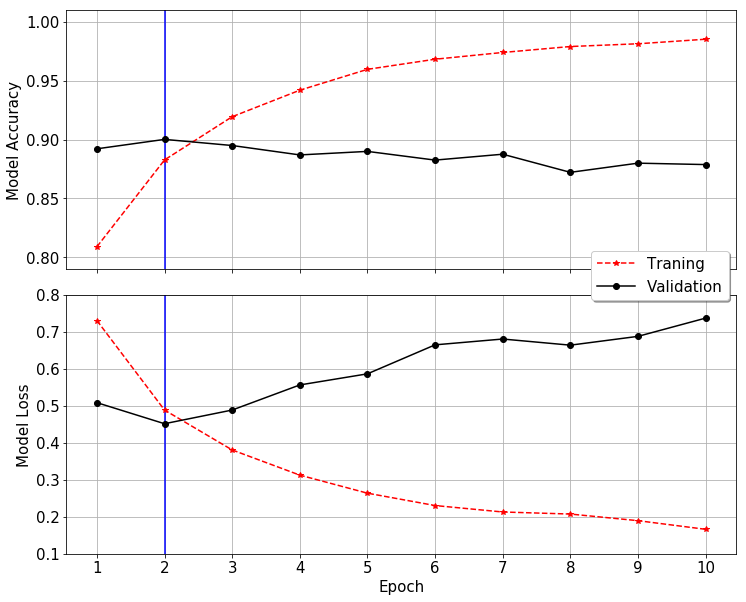

In [11]:
# Plot the training and validation accuracy and loss score

# Epoch with min loss
epoch_val_loss = np.argmin(history.history['val_loss'])

# Compute the min-max loss for plotting. Buffer 0.1 is for clear plot
min_loss = np.round(min(history.history['loss']+history.history['val_loss']),1)-0.1
max_loss = np.round(max(history.history['loss']+history.history['val_loss']),1)+0.1

# Compute the min-max acc for plotting. Buffer 0.1 is for clear plot
min_acc = np.round(min(history.history['acc']+history.history['val_acc']),1)-0.01
max_acc = np.round(max(history.history['acc']+history.history['val_acc']),1)+0.01

fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,10),sharex = True)
ax1.plot(history.history['acc'],'r*--')
ax1.plot(history.history['val_acc'],'ko-')
ax1.set(ylabel = 'Model Accuracy',
        xlabel = '',
        xticks = np.arange(1,10),
        ylim = [min_acc,max_acc])
ax1.grid()
ax1.vlines(epoch_val_loss,min_acc,max_acc, color = 'b')

ax2.plot(history.history['loss'],'r*--')
ax2.plot(history.history['val_loss'],'ko-')
ax2.set(ylabel = 'Model Loss',
        xlabel = 'Epoch',
        xticks = np.arange(0,10),
        xticklabels = np.arange(1,11),
        ylim = [min_loss,max_loss])
ax2.vlines(epoch_val_loss,min_loss,max_loss, color = 'b')
ax2.grid()
ax2.legend(['Traning', 'Validation'], loc='best',
           bbox_to_anchor=(1.0, 1.2),shadow=True, handlelength=2.5)
plt.subplots_adjust(hspace=0.1)
plt.show()

In [12]:
print('='*10,'Classification Report','='*10)
cr = classification_report(y_test_onehot, y_pred_onehot,target_names=class_names,output_dict=True)
cr['Hate'].update({'PR_auc' : average_precision_score(y_test_onehot[:,0], y_pred_prob[:,0],average='micro')} )
cr['Offensive'].update({'PR_auc' : average_precision_score(y_test_onehot[:,1], y_pred_prob[:,1],average='micro')} )
cr['Neutral'].update({'PR_auc' : average_precision_score(y_test_onehot[:,2], y_pred_prob[:,2],average='micro')} )
cr['micro avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='micro')})
cr['macro avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='macro')})
cr['weighted avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='weighted')})
cr['samples avg'].update({'PR_auc' : average_precision_score(y_test_onehot, y_pred_prob,average='samples')})
score_matrix = pd.DataFrame.from_dict(cr).T
np.round(score_matrix.iloc[:,:-1],4)

========== Classification Report ==========


,PR_auc,f1-score,precision,recall
Hate,0.2892,0.3416,0.3898,0.3040
Offensive,0.9735,0.9357,0.9247,0.9469
Neutral,0.8618,0.7828,0.8053,0.7616
micro avg,0.9461,0.8871,0.8871,0.8871
macro avg,0.7082,0.6867,0.7066,0.6708
weighted avg,0.9234,0.8833,0.8805,0.8871
samples avg,0.9395,0.8871,0.8871,0.8871


Normalized confusion matrix
[[0.30396476 0.5814978  0.11453744]
 [0.02341489 0.94685609 0.02972902]
 [0.02516556 0.21324503 0.7615894 ]]
Average precision score, micro-averaged over all classes: 0.95


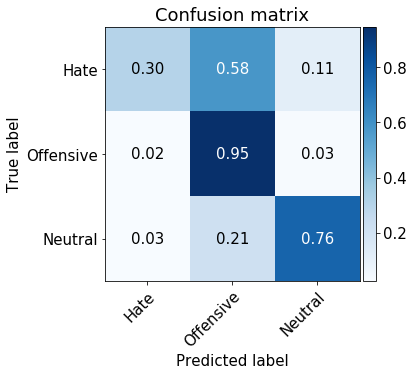

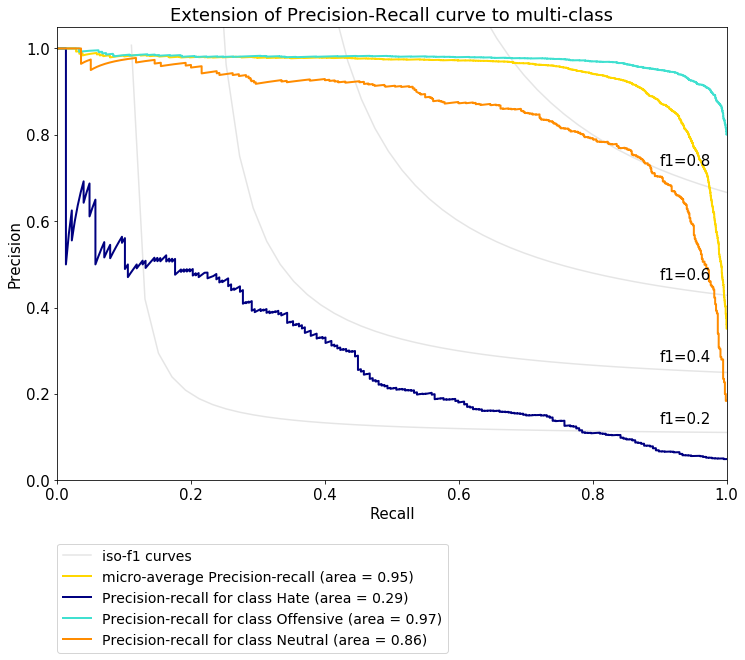

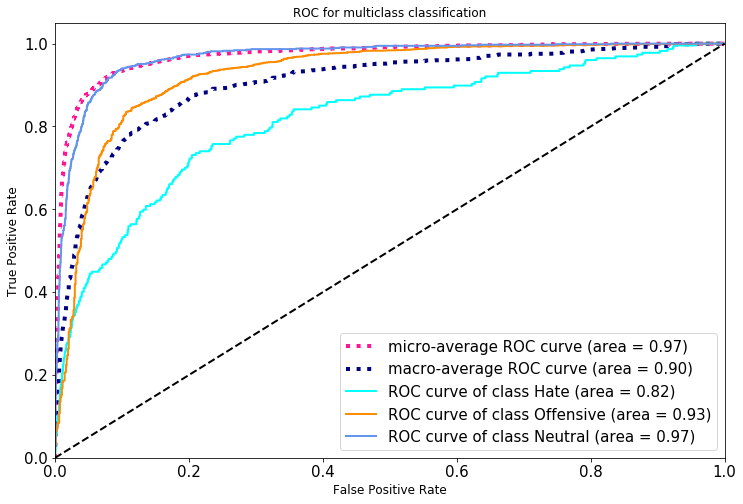

In [13]:
# Model confusion matrix
pm.plot_confusion_matrix(y_test.values, y_pred, classes=class_names,normalize = True,
                      title='Confusion matrix');
# Precision - Recall Curve
pm.prec_recall_curve(y_test_onehot, y_pred_prob,class_names)
# Reciever operator Curve
roc_auc = pm.ROC_curve(y_test_onehot, y_pred_prob,3)
